In [18]:
import os
import pydicom
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = "C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset"

def load_dicom_images(folder, size=(128, 128)):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith((".IMA", ".dcm")):  
                path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(path)
                    image = dicom_data.pixel_array
                    image = cv2.resize(image, size)
                    image = image.astype(np.float32) / np.max(image)  
                    images.append(image)
                except Exception as e:
                    print(f"Error {path}: {e}")
    print(f" {folder}: {len(images)}")
    return np.array(images)

original_data_path = os.path.join(DATASET_PATH, "Original Data")

quarter_dose_images = None
full_dose_images = None

for dose_type in ["Quarter Dose", "Full Dose"]:
    dose_path = os.path.join(original_data_path, dose_type)
    images = load_dicom_images(dose_path) 

    if dose_type == "Quarter Dose":
        quarter_dose_images = images
    else:
        full_dose_images = images 

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


quarter_dose_images = np.expand_dims(quarter_dose_images, axis=-1)
full_dose_images = np.expand_dims(full_dose_images, axis=-1)

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


Imagens Quarter Dose: (16628, 128, 128)
Imagens Full Dose: (16628, 128, 128)
Quarter Dose após expandir: (16628, 128, 128, 1)
Full Dose após expandir: (16628, 128, 128, 1)


In [31]:
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    
    # decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

autoencoder = build_autoencoder((128, 128, 1))
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(quarter_dose_images, full_dose_images, epochs=10, batch_size=8, shuffle=True)



Epoch 1/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 0.0065
Epoch 2/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - loss: 8.5537e-04
Epoch 3/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 6.9431e-04
Epoch 4/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - loss: 6.1786e-04
Epoch 5/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 1879s 904ms/step - loss: 5.6983e-04
Epoch 6/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 118s 57ms/step - loss: 5.3333e-04
Epoch 7/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 5.1393e-04
Epoch 8/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 1937s 932ms/step - loss: 4.9378e-04
Epoch 9/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 120s 58ms/step - loss: 4.8142e-04
Epoch 10/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 118s 57ms/step - loss: 4.6640e-04


In [33]:
def test_denoising(model, test_image):
    denoised_image = model.predict(np.expand_dims(test_image, axis=0))[0]
    return denoised_image

test_index = 5
test_image = quarter_dose_images[test_index]
clean_image = full_dose_images[test_index]
denosed_image = test_denoising(autoencoder, test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


SSIM: 0.8872


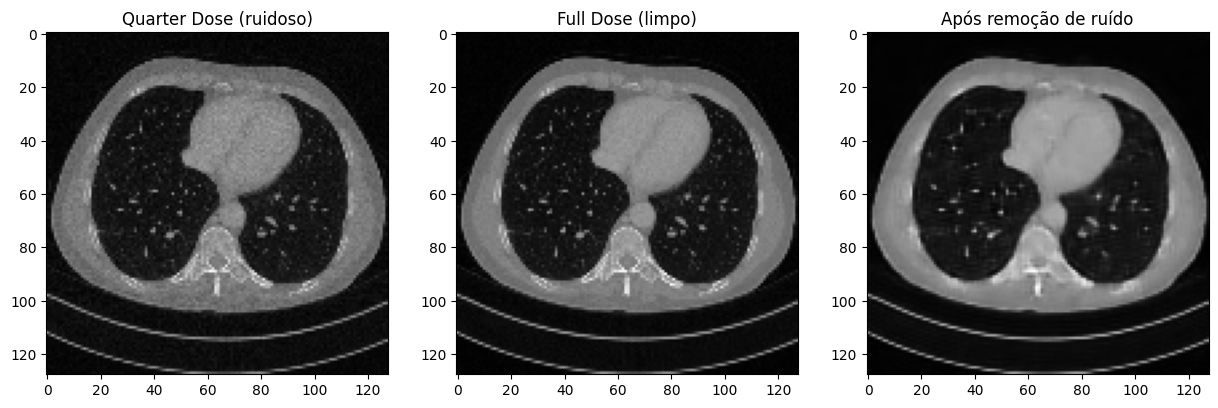

In [ ]:
similarity = ssim(clean_image.squeeze(), denosed_image.squeeze(), data_range=1.0)
print(f"SSIM: {similarity:.4f}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_image.squeeze(), cmap='gray')
ax[0].set_title("Quarter Dose")
ax[1].imshow(clean_image.squeeze(), cmap='gray')
ax[1].set_title("Full Dose")
ax[2].imshow(denosed_image.squeeze(), cmap='gray')
ax[2].set_title("Após remoção de ruído")
plt.show()

GENERATIVA

In [ ]:
DATASET_PATH = "C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset"

def load_dicom_images(folder, size=(128, 128)):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith((".IMA", ".dcm")):  
                path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(path)
                    image = dicom_data.pixel_array
                    image = cv2.resize(image, size)
                    image = image.astype(np.float32) / np.max(image)  
                    images.append(image)
                except Exception as e:
                    print(f"Error {path}: {e}")
    print(f" {folder}: {len(images)}")
    return np.array(images)

original_data_path = os.path.join(DATASET_PATH, "Original Data")

quarter_dose_images = None
full_dose_images = None

for dose_type in ["Quarter Dose", "Full Dose"]:
    dose_path = os.path.join(original_data_path, dose_type)
    images = load_dicom_images(dose_path) 

    if dose_type == "Quarter Dose":
        quarter_dose_images = images
    else:
        full_dose_images = images 

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


quarter_dose_images = np.expand_dims(quarter_dose_images, axis=-1)
full_dose_images = np.expand_dims(full_dose_images, axis=-1)

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")